In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [135]:
ADD_WEIGHT = 2.0
def read_img(path):
    t1 = cv2.imread(path)
    img = cv2.addWeighted(t1, ADD_WEIGHT, t1, 0, 0)
    return img

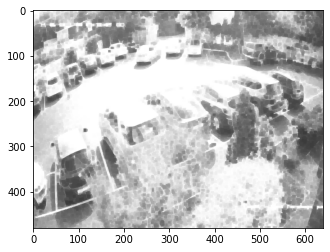

In [165]:

images = [
    cv2.cvtColor(read_img('testimages/cam1/consequtive/1.jpg'), cv2.COLOR_BGR2GRAY),
    cv2.cvtColor(read_img('testimages/cam1/consequtive/2.jpg'), cv2.COLOR_BGR2GRAY),
    cv2.cvtColor(read_img('testimages/cam1/consequtive/3.jpg'), cv2.COLOR_BGR2GRAY),
]
r = np.dstack(images)
median = np.median(r, axis=2).astype(np.uint8)
median = cv2.resize(median, (640, 480), interpolation=cv2.INTER_AREA)

def mcl(gray):
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    close = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel1)
    div = np.float32(gray)/(close)
    return np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))

# median = mcl(median)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# median = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel)
median = cv2.dilate(median, None, iterations=2)
median = cv2.erode(median, None, iterations=2)

plt.imshow(cv2.cvtColor(median, cv2.COLOR_GRAY2RGB))
plt.show()

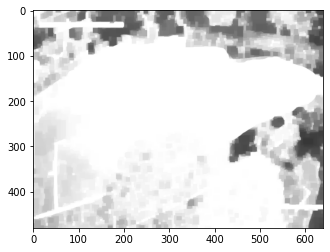

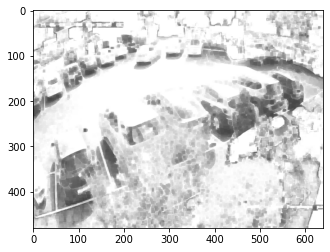

In [168]:
clean = cv2.imread("masks/clean.jpg")
clean = cv2.addWeighted(clean, ADD_WEIGHT, clean, 0, 0)
clean = cv2.cvtColor(clean, cv2.COLOR_BGR2GRAY)
clean = cv2.resize(clean, (640, 480), interpolation=cv2.INTER_AREA)
# clean = mcl(clean)
clean = cv2.dilate(clean, np.ones((5, 5), 'uint8'), iterations=3)
clean = cv2.erode(clean, np.ones((5, 5), 'uint8'), iterations=2)
plt.imshow(cv2.cvtColor(clean, cv2.COLOR_GRAY2RGB))
plt.show()

# clean = cv2.cvtColor(clean, cv2.COLOR_BGR2GRAY)
diff = cv2.subtract(clean, median)
diff = np.abs(diff).astype(np.uint8)
diff = 255 - diff
plt.imshow(cv2.cvtColor(diff, cv2.COLOR_GRAY2RGB))
plt.show()

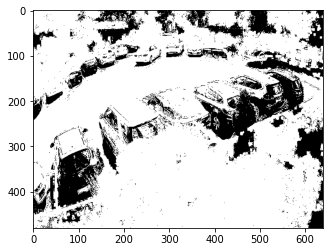

In [161]:
_,_thresh = cv2.threshold(diff,150,255,cv2.THRESH_BINARY)
# _thresh = cv2.adaptiveThreshold(diff,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3)

img = _thresh
plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
plt.show()

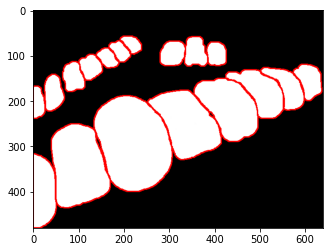

In [134]:
mask_orig = cv2.imread('masks/mask.png')
mask_orig = cv2.resize(mask_orig, (640, 480), interpolation=cv2.INTER_AREA)
mask_orig = cv2.cvtColor(mask_orig, cv2.COLOR_BGR2RGB)

r = mask_orig[:,:,0]

contours_r, _ = cv2.findContours(r, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

b = mask_orig[:,:,2]
contours_b, _ = cv2.findContours(b, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

contours = [
    contour for contour in (contours_b + contours_r)
    if 200 < cv2.contourArea(contour)
]

mask = cv2.bitwise_or(r, b)

mask_to_show = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
for contour in contours:
    cv2.drawContours(mask_to_show, [contour], 0, (255, 0, 0), 2)

plt.imshow(mask_to_show)
plt.show()

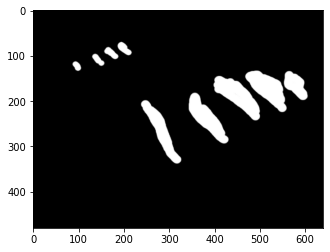

In [119]:
intersect_mask = mask_orig[:,:,1]
intersect_mask = cv2.bitwise_or(intersect_mask, intersect_mask)
plt.imshow(cv2.cvtColor(intersect_mask, cv2.COLOR_BGR2RGB))
plt.show()

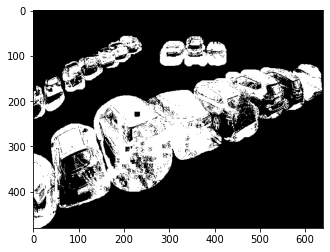

In [120]:
masked = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
plt.show()

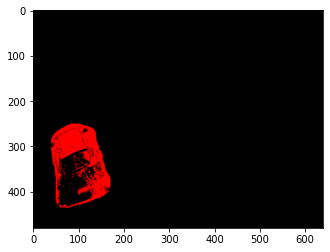

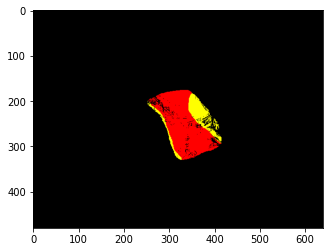

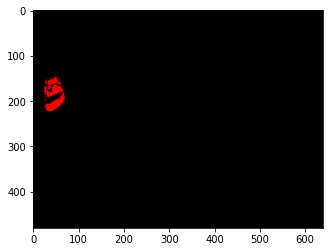

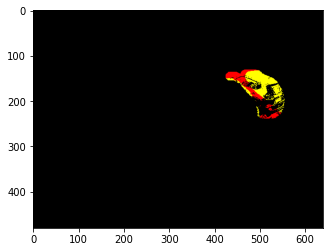

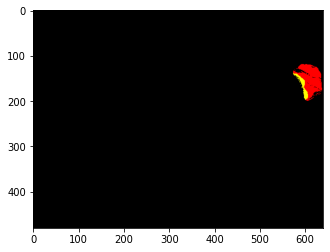

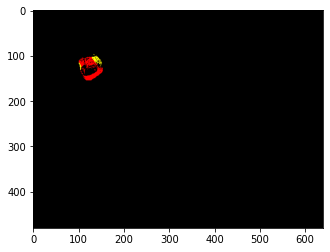

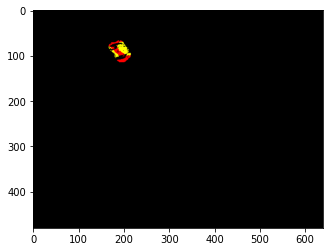

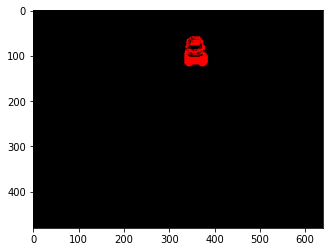

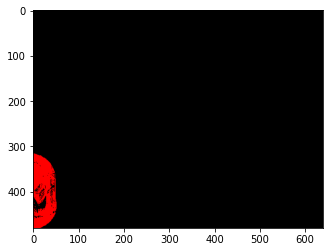

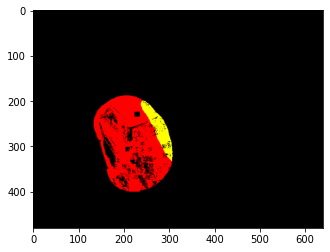

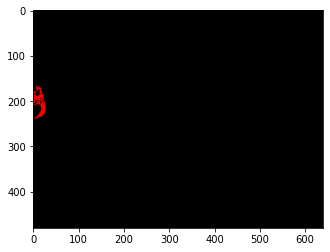

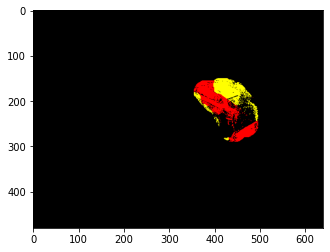

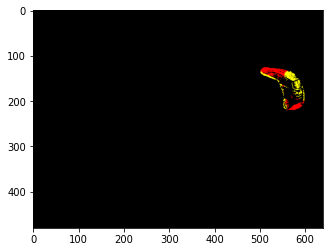

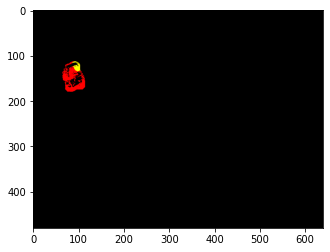

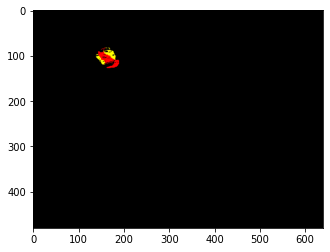

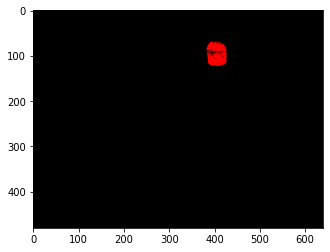

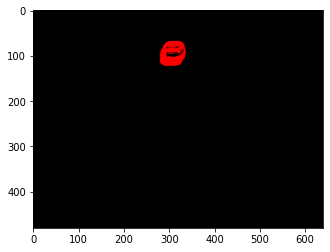

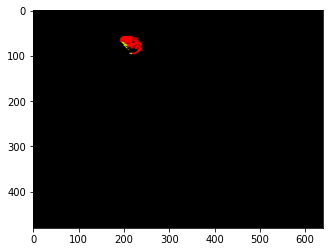

In [121]:
for contour in contours:
    lot_mask = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(lot_mask, [contour], -1, 255, -1)
    lot_intersection_mask = cv2.bitwise_and(lot_mask, intersect_mask)

    masked = cv2.bitwise_and(img, img, mask=lot_mask)
    # masked_intersection = cv2.bitwise_and(img, img, mask=lot_intersection_mask)
    intersection = cv2.bitwise_and(img, img, mask=lot_intersection_mask)

    # show
    _show = np.zeros((masked.shape[0], masked.shape[1], 3), np.uint8)
    # mask_to_show = masked.copy()

    _show[:,:,0] = masked
    _show[:,:,1] = intersection

    plt.imshow(_show)
    plt.show()

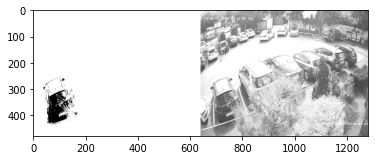

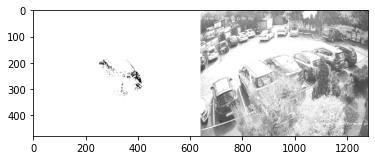

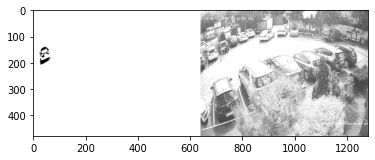

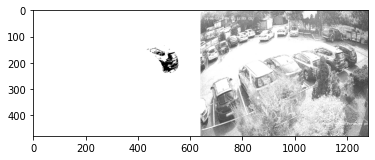

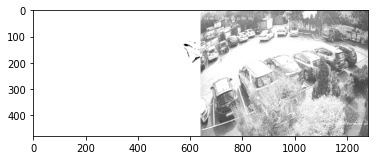

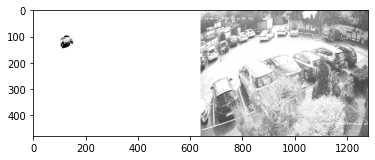

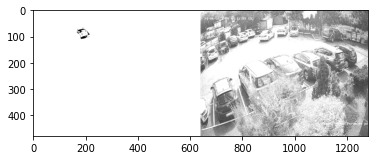

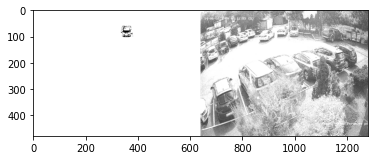

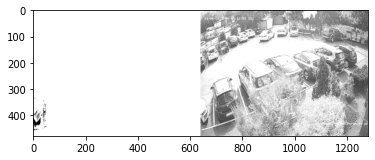

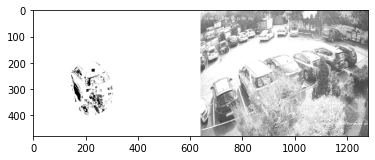

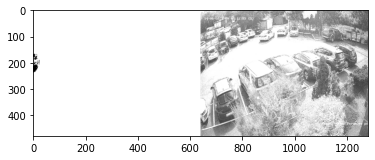

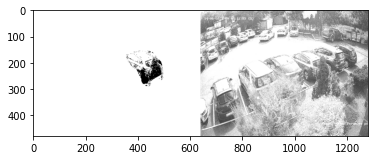

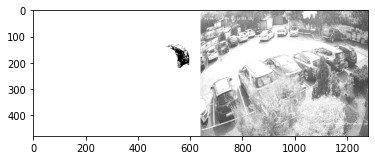

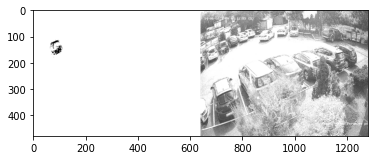

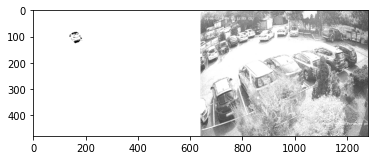

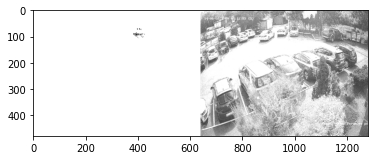

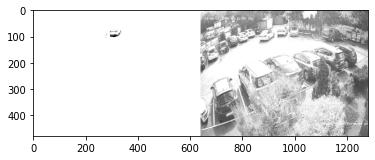

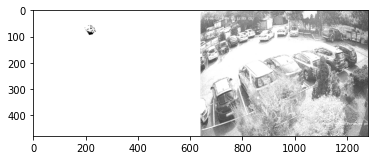

In [122]:
stored = []

for contour in contours:
    lot_mask = np.zeros(mask.shape, np.uint8)
    cv2.drawContours(lot_mask, [contour], -1, 255, -1)
    lot_intersection_mask = cv2.bitwise_and(lot_mask, intersect_mask)

    masked = cv2.bitwise_and(img, img, mask=lot_mask)
    masked = cv2.bitwise_or(masked, 255 - lot_mask)

    rate = np.count_nonzero(masked == 0) / float(np.count_nonzero(lot_mask != 0))

    stored.append((contour, rate))

    plt.imshow(cv2.cvtColor(cv2.hconcat([masked, median]), cv2.COLOR_GRAY2RGB))
    plt.show()

In [123]:
# def contour_center(contour):
#     M = cv2.moments(contour)
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
#
#     return cX, cY

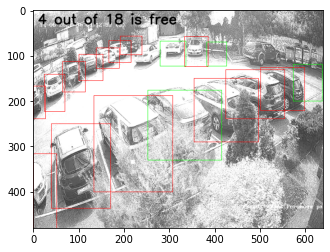

In [124]:
_result = cv2.cvtColor(median.copy(), cv2.COLOR_GRAY2RGB)
lots = len(stored)
free_lots = 0
for contour, rate in stored:
    # x, y = contour_center(contour)
    (x,y,w,h) = cv2.boundingRect(contour)

    if rate < 0.15:
        free_lots += 1
        cv2.rectangle(_result, (x, y), (x + w, y + h), (0, 255, 0), 1)
        # cv2.drawContours(_result, [contour], 0, (0, 255, 0), 2)
    else:
        cv2.rectangle(_result, (x, y), (x + w, y + h), (255, 0, 0), 1)

        # cv2.drawContours(_result, [contour], 0, (255, 0, 0), 2)

cv2.putText(_result, f'{free_lots} out of {lots} is free', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

plt.imshow(_result)
plt.show()